In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
check_path = os.path.join(strategy_path, 'check')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [11]:
# Comdty data
cindex_path = os.path.join(data_path, 'fut1return-com.CSV')
cindex2_path = os.path.join(data_path, 'BCOM.csv')

cindex = pd.read_csv(cindex_path, header=0, index_col=0, parse_dates=True)
cindex2 = pd.read_csv(cindex2_path, header=0, index_col=0, parse_dates=True)

CRet = cindex.pct_change(1).iloc[1:]
CRet2 = cindex2.pct_change(1).iloc[1:]
Cindex = (1. + CRet).cumprod()
Cindex = Cindex / Cindex.iloc[0]

In [ ]:
class CVA(CommodityStrategy):
    def __init__(self, strategy_name, asset_type):
        super().__init__(strategy_name=strategy_name, asset_type=asset_type)

    def calculate_signal(self, CS=0.35, nopos=0.6, lookback_period=63, minobs1=52):
        """

        :param cs_num: Percent of positions for Cross Sectional Signal
        :param nopos: no position zone in the middle of two extreme
        :param lookback_period: lookback period for calculating stdev
        :return:
        """
        self.logger.info('[STEP 3] CACULATE SIGNAL')

        # Notes. 대표님의 요구로 날씨 민감 그룹과 날씨 민감하지 않은 그룹을 나눠서 실제 했었음 > 나누지 않는 것이 더 나았음.
        for i in range(2):
            if i == 0:
                self.logger.info('[STEP 2 - 1] CACULATE SIGNAL FOR WEATHER GROUP')
                cret = self.ret[CommodityStrategy.BLOOM_COMMODITY_WEATHER_GROUP]
            if i == 1:
                self.logger.info('[STEP 2 - 2] CACULATE SIGNAL FOR NOT WEATHER GROUP')
                cret = self.ret[CommodityStrategy.BLOOM_COMMODITY_NOTWEATHER_GROUP]

            # Making Signal
            Retpos = cret[cret >= 0]
            Retpos.iloc[0] = 0
            Retneg = cret[cret <= 0]
            Retneg.iloc[0] = 0

            STDpos = Retpos.rolling(window=lookback_period, min_periods=1).std().fillna(0).iloc[lookback_period - 1:]
            STDneg = Retneg.rolling(window=lookback_period, min_periods=1).std().fillna(0).iloc[lookback_period - 1:]

            RV = STDneg - STDpos
            RV = RV[RV.index.weekday == self.rebalance_weekday]  # to weekly

            # 수정
#            RVrank = RV.iloc[minobs1 - 1:]
#            RVrank = RVrank * 0
#            for j in range(RV.shape[0] - minobs1 + 1):
#                RVrank.iloc[j, :] = RV.iloc[:minobs1 + j].rank().iloc[minobs1 + j - 1] / (
#                            (minobs1 + j) - RV.iloc[0:minobs1 + j].isna().sum())

            # 수정 전
            pctrank = lambda x: pd.Series(x).rank(pct=True, method='first').iloc[-1]
            RVrank = RV.expanding().apply(pctrank)  # it takes some time

            TSRV = RVrank.fillna(0) * 0
            TSRV[RVrank > nopos + (1 - nopos) / 2] = 1  # Long
            TSRV[RVrank < (1 - nopos) / 2] = -1  # Short

            # Cross Sectional Signal
            RV1 = RV.iloc[minobs1 - 1:]
            truecount = (RV1.notnull().sum(axis=1) * CS).apply(round)

            CSRV = (RV1).rank(axis=1, method='first')  # Short
            CSRV1 = (CSRV.count(1).T + 1 - CSRV.T).T

            CSRVpos = CSRV.fillna(0) * 0
            CSRVpos[CSRV.apply(lambda x: x <= truecount, axis=0)] = -1
            CSRVpos[CSRV1.apply(lambda x: x <= truecount, axis=0)] = 1
            CSRV = CSRVpos

            if i == 0:
                TSRVrun1 = TSRV
                CSRVrun1 = CSRV
            if i == 1:
                TSRVrun2 = TSRV
                CSRVrun2 = CSRV

        TSRV = pd.concat([TSRVrun1, TSRVrun2], axis=1)
        CSRV = pd.concat([CSRVrun1, CSRVrun2], axis=1)

        TSRV = TSRV[self.ret.columns]
        CSRV = CSRV[self.ret.columns]

        self.TSRV = TSRV.loc[self.ret.index].fillna(method='ffill').dropna(how='all')
        self.CSRV = CSRV.loc[self.ret.index].fillna(method='ffill').dropna(how='all')

        # Align dates with each other
        if self.TSRV.index[0] > self.CSRV.index[0]:
            self.CSRV = self.CSRV.loc[self.TSRV.index[0]:]
        else:
            self.TSRV = self.TSRV.loc[self.CSRV.index[0]:]

In [4]:
class CVA(CommodityStrategy):
    def __init__(self, strategy_name, asset_type):
        super().__init__(strategy_name=strategy_name, asset_type=asset_type)

    def calculate_signal(self, CS=0.35, nopos=0.6, lookback_period=63, minobs1=52):
        """

        :param cs_num: Percent of positions for Cross Sectional Signal
        :param nopos: no position zone in the middle of two extreme
        :param lookback_period: lookback period for calculating stdev
        :return:
        """
        self.logger.info('[STEP 3] CACULATE SIGNAL')

        # Notes. 대표님의 요구로 날씨 민감 그룹과 날씨 민감하지 않은 그룹을 나눠서 실제 했었음 > 나누지 않는 것이 더 나았음.
        self.logger.info('[STEP 2] CACULATE SIGNAL')
        cret = self.ret

        # Making Signal
        Retpos = cret[cret >= 0]
        Retpos.iloc[0] = 0
        Retneg = cret[cret <= 0]
        Retneg.iloc[0] = 0

        STDpos = Retpos.rolling(window=lookback_period, min_periods=1).std().fillna(0).iloc[lookback_period - 1:]
        STDneg = Retneg.rolling(window=lookback_period, min_periods=1).std().fillna(0).iloc[lookback_period - 1:]

        RV = STDneg - STDpos
        RV = RV[RV.index.weekday == self.rebalance_weekday]  # to weekly

        # 수정
#            RVrank = RV.iloc[minobs1 - 1:]
#            RVrank = RVrank * 0
#            for j in range(RV.shape[0] - minobs1 + 1):
#                RVrank.iloc[j, :] = RV.iloc[:minobs1 + j].rank().iloc[minobs1 + j - 1] / (
#                            (minobs1 + j) - RV.iloc[0:minobs1 + j].isna().sum())

        # 수정 전
        pctrank = lambda x: pd.Series(x).rank(pct=True, method='first').iloc[-1]
        RVrank = RV.expanding().apply(pctrank)  # it takes some time

        TSRV = RVrank.fillna(0) * 0
        TSRV[RVrank > nopos + (1 - nopos) / 2] = 1  # Long
        TSRV[RVrank < (1 - nopos) / 2] = -1  # Short

        # Cross Sectional Signal
        RV1 = RV.iloc[minobs1 - 1:]
        truecount = (RV1.notnull().sum(axis=1) * CS).apply(round)

        CSRV = (RV1).rank(axis=1, method='first')  # Short
        CSRV1 = (CSRV.count(1).T + 1 - CSRV.T).T

        CSRVpos = CSRV.fillna(0) * 0
        CSRVpos[CSRV.apply(lambda x: x <= truecount, axis=0)] = -1
        CSRVpos[CSRV1.apply(lambda x: x <= truecount, axis=0)] = 1
        CSRV = CSRVpos

        TSRV = TSRV[self.ret.columns]
        CSRV = CSRV[self.ret.columns]

        self.TSRV = TSRV.loc[self.ret.index].fillna(method='ffill').dropna(how='all')
        self.CSRV = CSRV.loc[self.ret.index].fillna(method='ffill').dropna(how='all')

        # Align dates with each other
        if self.TSRV.index[0] > self.CSRV.index[0]:
            self.CSRV = self.CSRV.loc[self.TSRV.index[0]:]
        else:
            self.TSRV = self.TSRV.loc[self.CSRV.index[0]:]

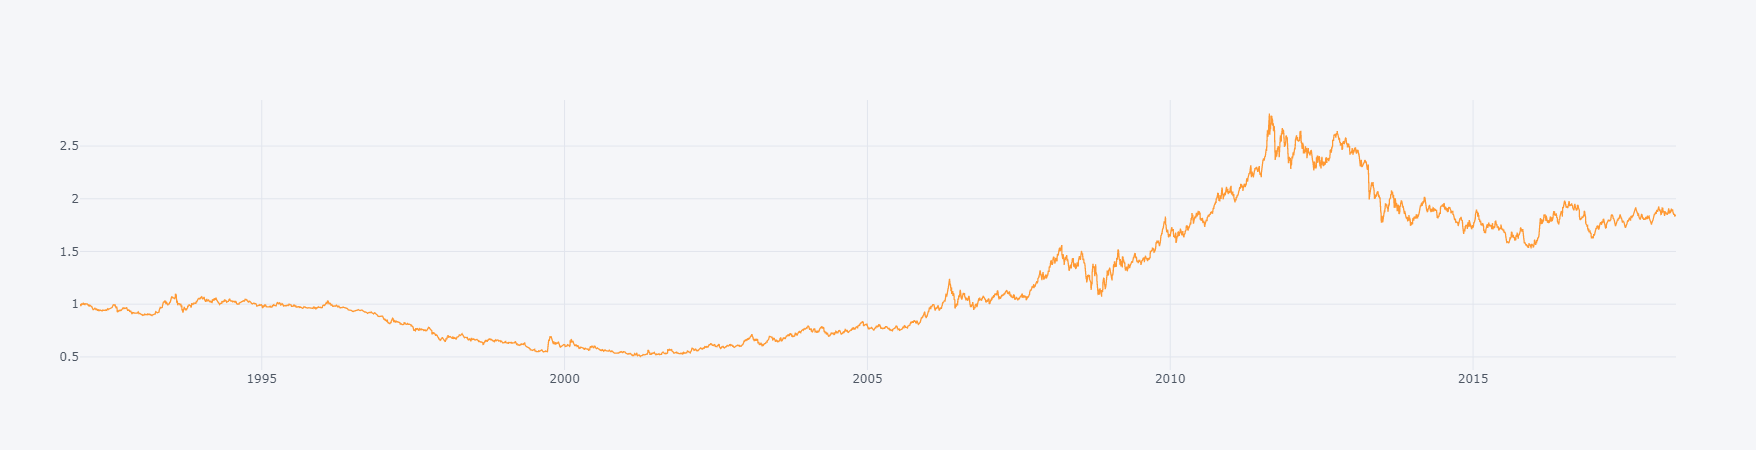

In [14]:
Cindex['GC'].iplot()

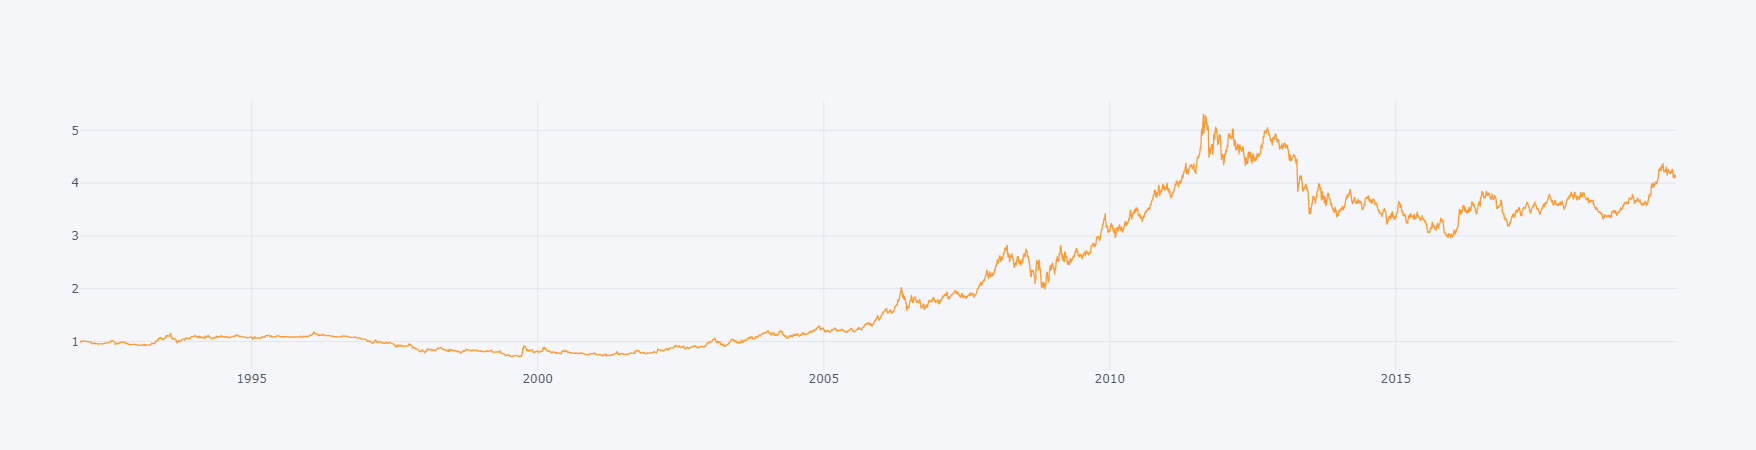

In [15]:
cva.index['GC'].iplot()

In [5]:
cva = CVA(strategy_name="CVA", asset_type="COMMODITY")
cva.load_index_and_return(from_db=False, save_file=False)
cva.set_rebalance_period(ts_freq='week', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
cva.calculate_signal(CS=0.35, nopos=0.6, lookback_period=63)
cva.set_portfolio_parameter(cs_strategy_type='vol', min_vol=0.15)
cva.make_portfolio()

2020-01-06 16:31:54,317 - CVA - INFO - [STEP 0] START LOGGING CVA
2020-01-06 16:31:54,320 - CVA - INFO - [STEP 1] LOAD DATA
2020-01-06 16:31:54,320 - CVA - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2020-01-06 16:31:54,363 - CVA - INFO - [STEP 2] SET REBALANCE PERIOD
2020-01-06 16:31:54,363 - CVA - INFO - [STEP 3] CACULATE SIGNAL
2020-01-06 16:31:54,364 - CVA - INFO - [STEP 2] CACULATE SIGNAL
C:\Users\kihyun.nam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

C:\Users\kihyun.nam\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alt

In [6]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
cva_comp_df = pd.read_csv('./past/cva.csv', header=0, index_col=0, parse_dates=True)
cva_lag_comp_df = pd.read_csv('./past/cva_lag.csv', header=0, index_col=0, parse_dates=True)

In [7]:
tester = Tester(cva)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

2020-01-06 16:33:20,452 - CVA - INFO - [STEP 6] START BACKTEST
2020-01-06 16:33:20,453 - CVA - INFO - [STEP 6 - 1] BACKTEST CVA TIME SERIES
2020-01-06 16:33:21,340 - CVA - INFO - [STEP 6 - 2] BACKTEST CVA CROSS SECTIONAL


In [8]:
to_plot = (1.+ cva_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

In [18]:
to_plot = (1.+ cva_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()